# Final Project: Model Training 
In this Jupyter notebook, I will be training my three models. The first model is a Classic Model (non neural-network), the second is a Neural Network (CNN) model, and the third is a Multimodal NN. 

## Training Model #1: Linear Regression 

In [1]:
# necessary imports 
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from utils import standardize_numeric

# Model 1: Classic Model -- importing the UTKFaceAugmented.csv file and extracting features to predict age 
df = pd.read_csv('data/UTKFaceAugmented.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
print(df.columns.tolist())
print(len(df))
df.head(5) # prints out the first five rows of data 

# listing the numerical vs categorical columns of data 
numeric_col = ['age', 'max_annual_earnings','num_haircuts_life']
categorical_col = ['gender', 'filename', 'age_range', 'has_tiktok', 'remembers_disco', 'uses_skincare'] 

df['age_st'] = standardize_numeric(df['age'], False)
df['max_annual_earnings_st'] = standardize_numeric(df['max_annual_earnings'], False)
df['num_haircuts_life_st'] = standardize_numeric(df['num_haircuts_life'], False)

# splitting the data into features and targets 
X = df[['max_annual_earnings_st', 'num_haircuts_life_st']]
y = df['age']


['Unnamed: 0', 'filename', 'age', 'gender', 'race', 'age_range', 'num_haircuts_life', 'has_tiktok', 'remembers_disco', 'uses_skincare', 'max_annual_earnings']
23708


### Splitting the Data and Evaluating the Model

In [2]:
# splitting the data into training and testing set using an 80-20 split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Absolute Error: 6.38224379960849
Mean Squared Error: 71.14407146428347
R-squared: 0.8207562809203677


## Training for Model #2: CNN 

### Uploading and understanding the data

In [3]:
import torch.nn as nn
from PIL import Image
import pandas as pd
import os 
import math

# code is adopted from CNN Lab 
image_dir = r'/Users/camillerosevalencia/Downloads/images'

data = pd.read_csv('data/UTKFaceAugmented.csv')

# temporary arrays to hold images and labels 
images = []
labels = []

# for-loop to load up the images and preprocess them 
for index, row in data.iterrows():
    filename = row['filename']  
    age_label = row['age']  
    image_path = os.path.join(image_dir, filename)
    if os.path.exists(image_path):  # Check if the file exists before processing
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        img = img.resize((64, 64))
        img_tensor = torch.tensor(np.array(img) / 255.0, dtype=torch.float32)
        images.append(img_tensor.unsqueeze(0))  # Add a batch dimension
        labels.append(age_label)
    else:
        print(f"File not found: {image_path}")


image_tensor = torch.cat(images, dim=0)
labels = torch.tensor(labels, dtype=torch.float32)

In [4]:
# prepare our data for our CNN. a torch CNN expects data to follow this format
# [batch_size, channels, pixels horizontal, pixels vertical]
# Function to calculate output shape after convolution
def calculate_output_shape(image_size, kernel, stride, padding):
    assert len(image_size) == len(kernel) == len(stride) == len(padding), "All values should have the same length"
    output_shape = []
    for dim in range(len(image_size)):
        output = 1 + (image_size[dim] + (2 * padding[dim]) - kernel[dim]) / stride[dim]
        assert output.is_integer(), "Change kernel size, padding, and stride to get an integer value for the output"
        output_shape.append(int(output))
    return output_shape

# Calculate output shape after convolution
output_shape = calculate_output_shape([8, 8], [3, 3], [3, 3], [2, 2])
print("Output Shape after Convolution:", output_shape)

# Create a convolutional layer with adjusted kernel size
conv = nn.Conv2d(
    in_channels=3,  # 3 channels RGB
    out_channels=64,  # Number of kernels to train
    kernel_size=(3, 3),  # Adjusted kernel size to demonstrate convolution
    stride=(1, 1),
    padding=(2, 2)
)

# Create a random input image (8x8x1)
image_np = np.random.randn(3, 3, 8, 8).astype(np.float32)
image_tensor = torch.from_numpy(image_np)
output = conv(image_tensor)

Output Shape after Convolution: [4, 4]


In [5]:
# Extract indices where target equals 8
indices = (image_tensor == 1).nonzero(as_tuple=True)

# Use the extracted indices to get corresponding data and target values
x = image_tensor[indices[:20]]
y = image_tensor[indices[:20]]
print(x,y)

# prep the data for training
x = np.reshape(x, (len(x), 8, 1, 1))
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# prep the data for training
x = np.reshape(x, (len(x), 8, 1, 1))
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

conv_1kernel = nn.Conv2d(
    in_channels=1,
    out_channels=1,
    kernel_size=(20,20),
    stride=(1, 1),
    padding=(1, 1)  
)

optimizer = torch.optim.Adam(conv_1kernel.parameters(), lr = 0.001)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction = 'none')

# initializing a list for kernels 
kernels = []

# adding to the initial kernel 
kernels.append(conv_1kernel.weight.data.detach().numpy().copy())

optimizer = torch.optim.Adam(conv_1kernel.parameters(), lr = 0.001)
loss_fn = torch.nn.BCEWithLogitsLoss(reduction = 'none')


kernels.append([param.detach().numpy().copy() for param in conv_1kernel.parameters()][0])
for _ in range(10):
    for i in range(len(x)):
        optimizer.zero_grad()
        yhat = torch.squeeze(conv_1kernel(x[i:i+1]))
        loss = loss_fn(y[i], yhat)
        loss.backward()
        optimizer.step()
    kernels.append([param.detach().numpy().copy() for param in conv_1kernel.parameters()][0])

tensor([]) tensor([])


/var/folders/_2/lc4kd1ss73gd84fzt4gfbt_w0000gn/T/ipykernel_6964/969464768.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/var/folders/_2/lc4kd1ss73gd84fzt4gfbt_w0000gn/T/ipykernel_6964/969464768.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32)
/var/folders/_2/lc4kd1ss73gd84fzt4gfbt_w0000gn/T/ipykernel_6964/969464768.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/var/folders/_2/lc4kd1ss73gd84fzt4gfbt_w

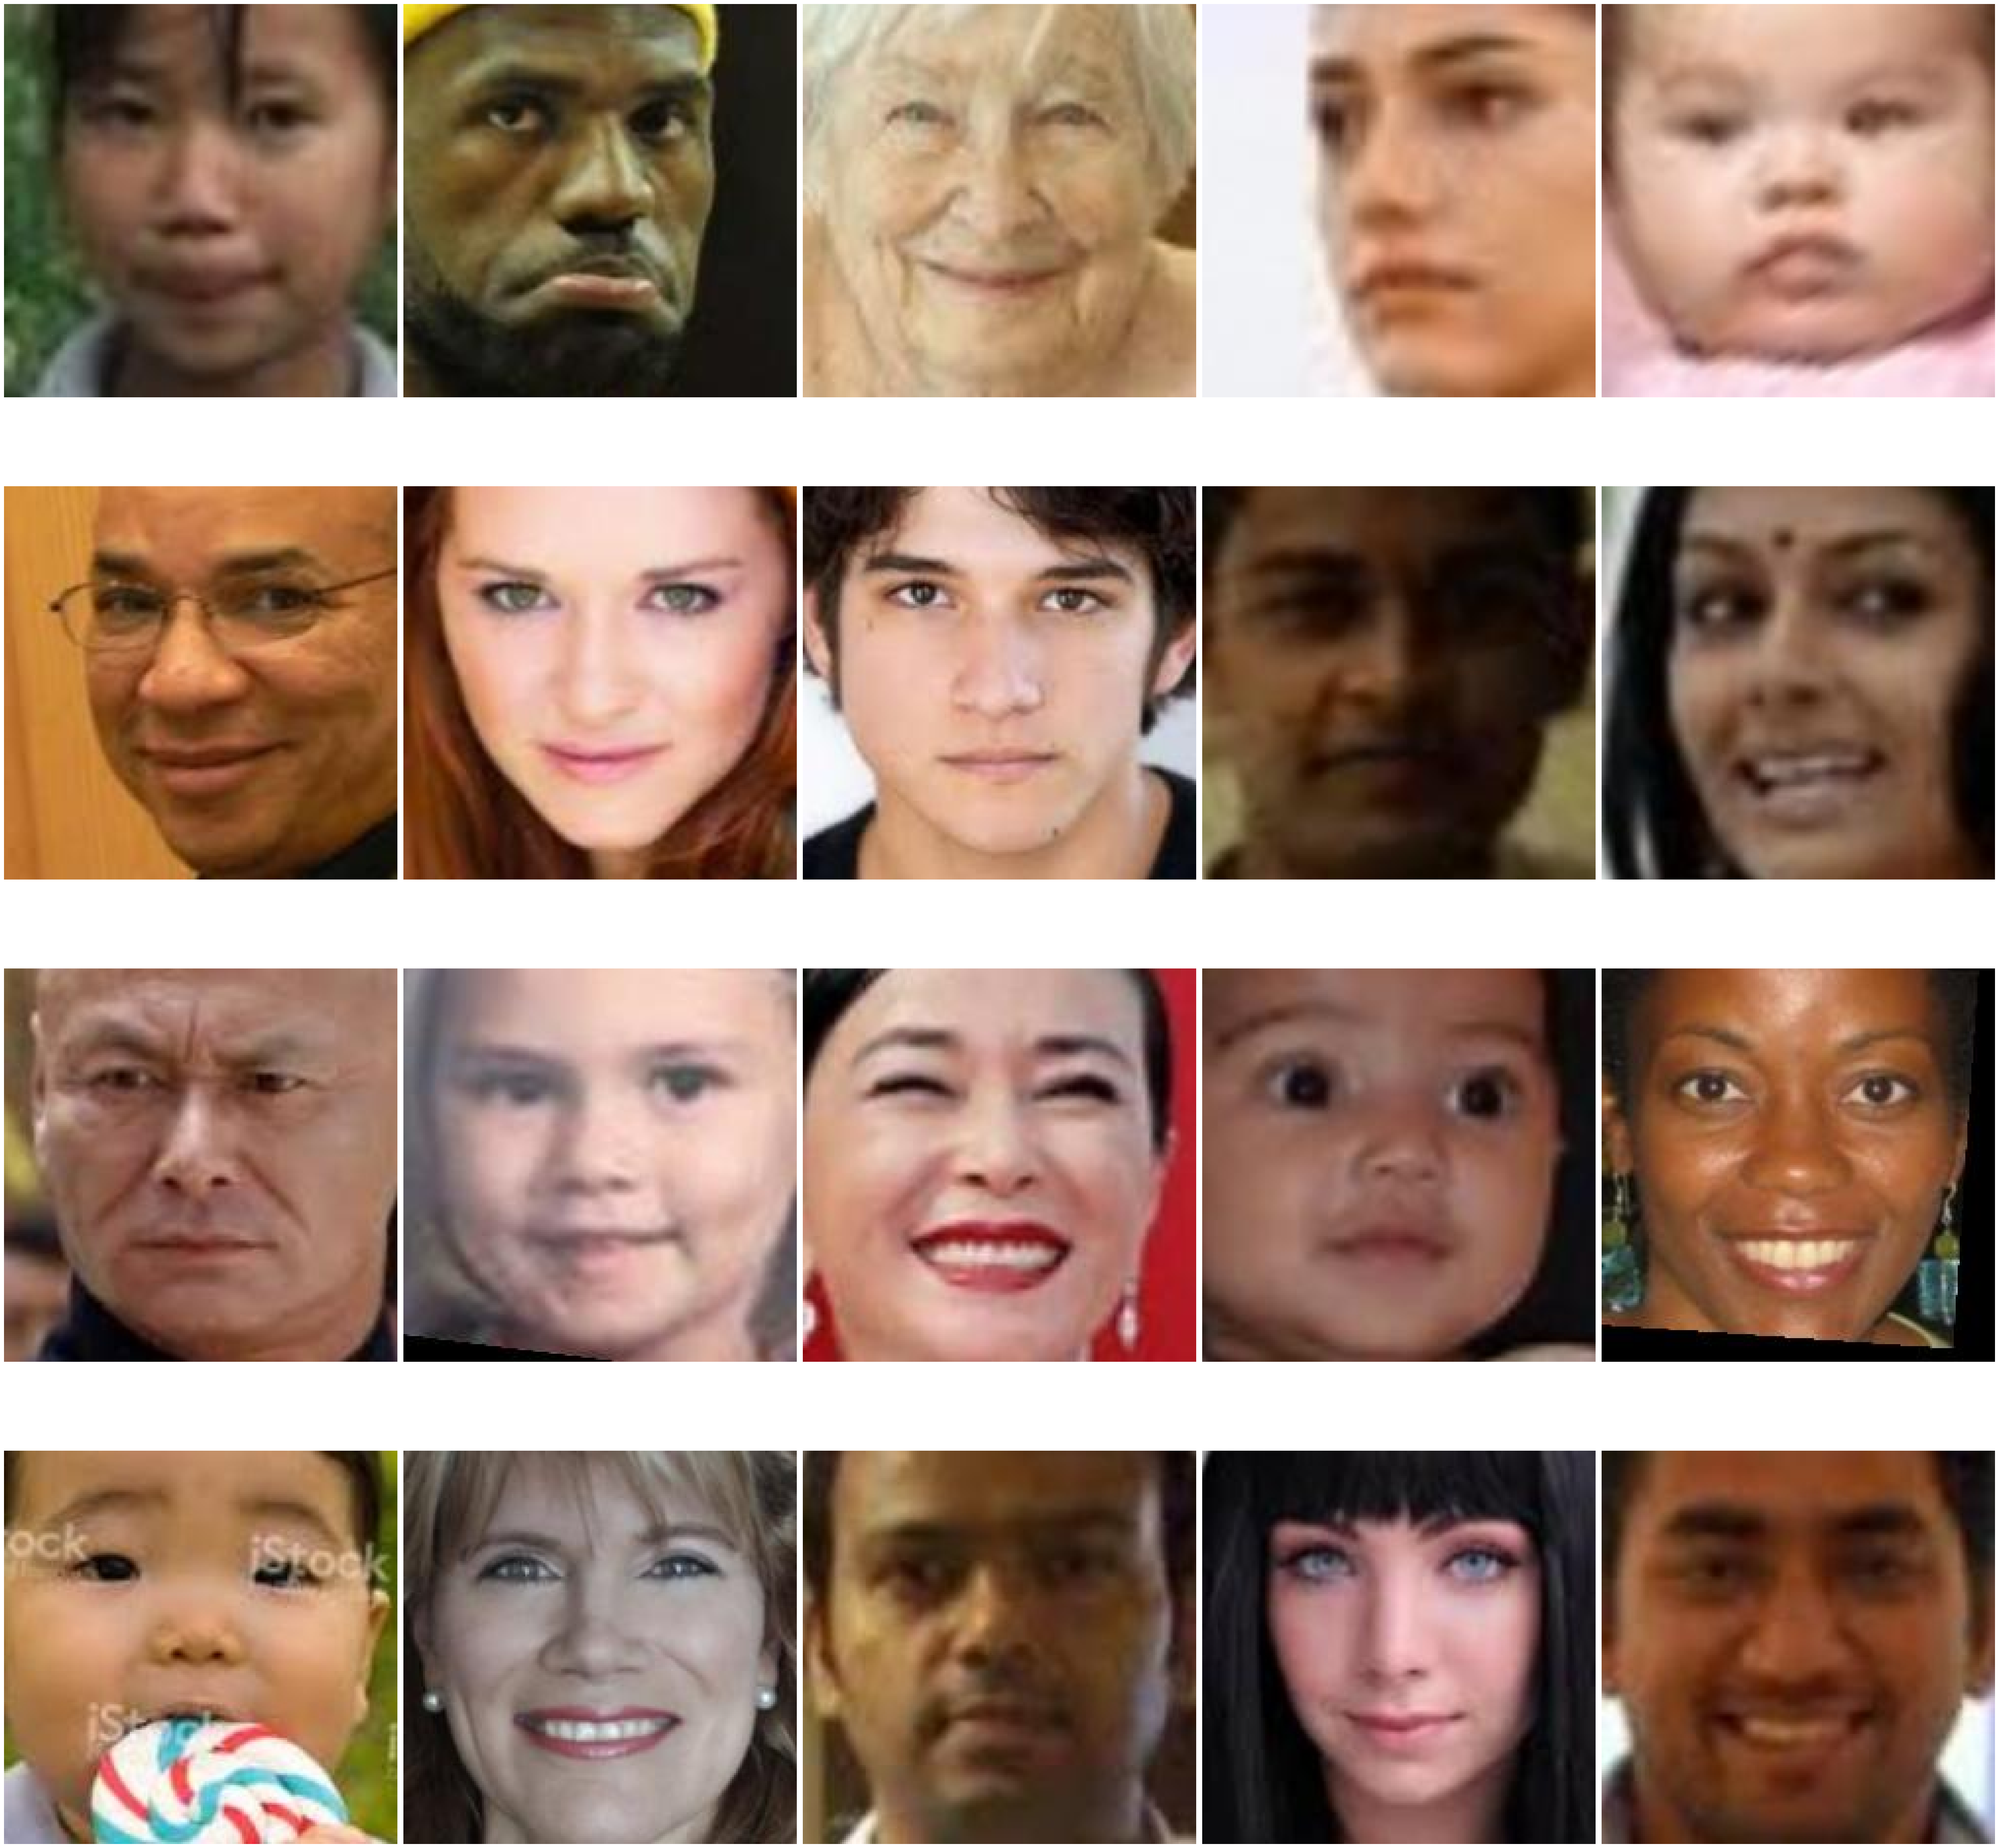

<Figure size 640x480 with 0 Axes>

In [6]:
# we can fetch an item from the data like so, which gives us the image in PIL form, and the class label as an int
image_data_list = []
count = 0

# Loop through image files in the directory
for filename in os.listdir(image_dir):
    # Check if the file is an image (ends with .jpg)
    if filename.endswith(".jpg"):
        # Construct the full path to the image file
        image_path = os.path.join(image_dir, filename)
        
        # Open the image using PIL
        img = Image.open(image_path)
        
        # Convert the image to a NumPy array and append to the list
        img_array = np.array(img)
        image_data_list.append(img_array)
        # Increment count
        count += 1
        
        # Break the loop when 1000 images are read
        if count >= 20:
            break

# converting the list of image arrays to a NumPy array
image_data = np.array(image_data_list, dtype=np.float32)

num_rows = 4  # 20 images in 4 rows
num_cols = 5  # 5 images per row

# create a subplot grid to display multiple images
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 50))

# flatten the axes array for easy iteration
axes = axes.flatten()

# displays some of the images in a grid format 
image_data_normalized = image_data / 255.0 
for i in range(20):
    axes[i].imshow(image_data_normalized[i], cmap='viridis')  #  colormap viridis
    axes[i].axis('off')

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

I used this visual output from the cell above to see what the images look like and what kind of augmentations were applied. As shown, some images have higher resolution, some have watermarks, and some are aligned differently. 

### Importing the Model and Dataloader

In [7]:
# necessary imports 
from networks import CNNClassifier
from dataloader import ImageDataloader
import torch
import math
import torch.nn as nn
from PIL import Image

In [8]:
x_train, x_test, y_train, y_test = train_test_split(image_data, labels[:20], test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.4, random_state=42)

# converting the data to PyTorch tensors
x_train = torch.stack([torch.tensor(np.array(img), dtype=torch.float32) for img in x_train])
x_val = torch.stack([torch.tensor(np.array(img), dtype=torch.float32) for img in x_val])
x_test = torch.stack([torch.tensor(np.array(img), dtype=torch.float32) for img in x_test])

num_classes = 40
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

y_train = np.clip(y_train, 0, num_classes - 1)
y_val = np.clip(y_val, 0, num_classes - 1)
y_test = np.clip(y_test, 0, num_classes - 1)

# one-hot encoding the training, validation and test sets 
y_train = torch.tensor(y_train, dtype=torch.int64)
y_train = torch.nn.functional.one_hot(y_train, num_classes=num_classes)

y_val = torch.tensor(y_val, dtype=torch.int64)
y_val = torch.nn.functional.one_hot(y_val, num_classes=num_classes)

y_test = torch.tensor(y_test, dtype=torch.int64)
y_test = torch.nn.functional.one_hot(y_test, num_classes=num_classes)

x = []
y = []

for i in range(len(image_data[:20])):
    img = image_data[i]
    label = []
    x.append(torch.tensor(np.array(img), dtype=torch.float32))
    y.append(label)

# validation data 
x = []
y = []
for img_tensor in x_train:
    x.append(torch.tensor(np.array(img_tensor), dtype=torch.float32))

for i in range(20):
    img = image_data[i]
    label = []
    x.append(torch.tensor(np.array(img), dtype=torch.float32))
    y.append(label)
    
# stacking x creates the x_val tensor
x_val = torch.stack(x)
x_val = torch.unsqueeze(x_val, 1)  # Reshape x_val if needed

# one-hot encoding the labels into y_val tensor
num_classes = 10
y_val = torch.zeros(len(y), num_classes)
y_indices = torch.tensor(y, dtype=torch.long)

y_val = torch.zeros(len(y), num_classes)

# assigning 1s to specific positions
x_val = torch.stack(x)
x_val = torch.unsqueeze(x_val, 1)
y_val = torch.zeros(len(y),1)

In [9]:
import tqdm

# instantiating the training and validation dataloaders
train_dataloader = ImageDataloader(x = x_train, y = y_train, batch_size=200, randomize=True)
val_dataloader = ImageDataloader(x = x_val, y = y_val, batch_size=200, randomize=False)

# instantiating my model 
model = CNNClassifier(output_dim=1)

# instantiating my optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# logging my training and validation losses
train_losses = []
#val_losses = []

# number of epochs to train on 
epochs = 80

# for this loss function I am using Mean Squared Error (MSE) 
loss_fn = torch.nn.MSELoss(reduction='mean')

# training loop 
for _ in tqdm.tqdm(range(epochs)):
    model.train()
    losses = []
    for _ in range(train_dataloader.num_batches_per_epoch):
        # training data forward pass
        optimizer.zero_grad()
        train_batch = train_dataloader.fetch_batch()
        yhat = model(train_batch['x_batch'])
        train_loss = torch.mean(loss_fn(yhat.float(), train_batch['y_batch'].float()))

        # training data backward pass
        train_loss.backward()
        optimizer.step()
        losses.append(train_loss.detach().numpy())
    
    train_losses.extend(losses)

    # validation portion -- I tried plotting my validation, but I kept getting errors  
   # model.eval()
    #val_losses_batch = []
    #with torch.no_grad():
        #for _ in range(val_dataloader.num_batches_per_epoch):
            #val_batch = val_dataloader.fetch_batch()
            #yhat_val = model(val_batch['x_batch'])
            #val_loss = torch.mean(loss_fn(yhat_val.float(), val_batch['y_batch'].float()))
            #val_losses.append(val_loss.detach().numpy())
    
    torch.save(model.state_dict(), "model_checkpoints/model.pt")

  0%|                                                    | 0/80 [00:00<?, ?it/s]/Users/camillerosevalencia/Documents/ECEGR4750/.venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14, 40])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████| 80/80 [00:01<00:00, 51.89it/s]


### Analyzing the Results

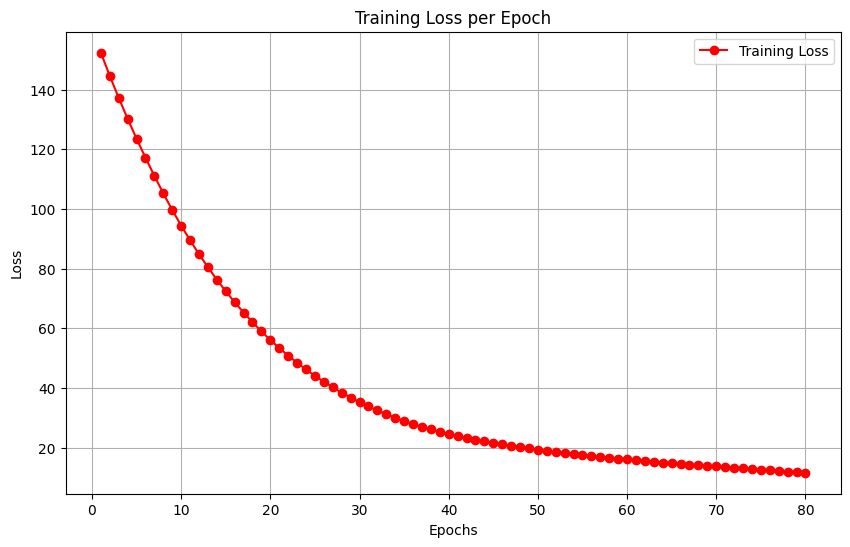

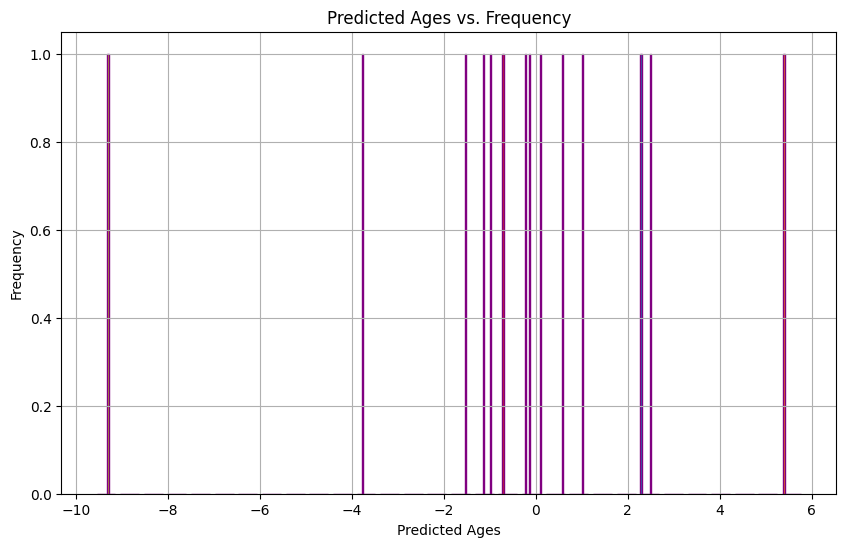

In [10]:
# plotting the training loss acrued per epoch 
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

# worked with Jess to create a predict_age function, but it didn't work for the both of us 
def predict_age(model, ImageDataLoader):
    model.eval()
    predicted_ages = []
    
    with torch.no_grad():
        for _ in range(ImageDataLoader.num_batches_per_epoch):
            batch = ImageDataLoader.fetch_batch()
            yhat = model(batch['x_batch'])
            predicted_ages.extend(yhat.cpu().numpy()) 
    
    return predicted_ages

# Use the trained model and validation dataloader to predict ages
predicted_ages = predict_age(model, train_dataloader) 

# Plot a histogram of predicted ages -- the ages seemed to be getting normalized, I'm not sure why though 
plt.figure(figsize=(10, 6))
plt.hist(predicted_ages, bins=30, edgecolor='purple')
plt.xlabel('Predicted Ages')
plt.ylabel('Frequency')
plt.title('Predicted Ages vs. Frequency')
plt.grid(True)
plt.show()


## Training Model #3: Multi-Modal Neural Network 

In [14]:
# necessary imports 
#from dataloader import CustomMultimodalDataloader
#from networks import MultimodalNN
#from utils import mean_squared_error 

In [15]:
# loading in the dataset -- images, features and ages 
#df = pd.read_csv('data/UTKFaceAugmented.csv')
#features = ['max_annual_earnings','num_haircuts_life','gender', 'filename', 'age_range', 'has_tiktok', 'remembers_disco', 'uses_skincare'] 
#target = ['age']

In [16]:
# declaring the batch size and instantiating my MM dataloader
#batch_size = 32
#dataloader = CustomMultimodalDataloader(images, features, ages, batch_size=batch_size)

# instantiating my multimodal NN 
#model = MultimodalNN(image_dim=your_image_dimension, feature_dim=your_feature_dimension, output_dim=1)

# Training loop
#num_epochs = 10
#learning_rate = 0.001

#for epoch in range(num_epochs):
    #total_loss = 0

    #for batch_data in dataloader:
        #batch_images, batch_features, batch_ages = batch_data

        # Forward pass
        #forward_pass_data = forward_pass(model, batch_images, batch_features)
        #predictions = forward_pass_data['fc2']['output']

        # Compute loss (mean squared error)
        #loss = mean_squared_error(predictions, batch_ages)
        #total_loss += loss

        # Backward pass (gradient descent)
        #compute_gradients(forward_pass_data, batch_ages, predictions)

    #average_loss = total_loss / len(dataloader)
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

NameError: name 'ages' is not defined